# Libraries

In [3]:
import sys
sys.path.append(r'C:/Users/Chi Nguyen/Desktop/breast-cancer-detection/pytorch/pytorch-image-models')
import timm

In [4]:
timm.__version__

'0.8.1dev0'

In [39]:
import os
import sys
import shutil
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import timm

from tqdm.notebook import tqdm
import pytorch_lightning as pl
import torchmetrics

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from accelerate import Accelerator, notebook_launcher
from sklearn.metrics import f1_score

# Metric - Probabilistic F1

In [6]:
def probabilistic_f1(labels, predictions, beta=0.5):
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(predictions[idx], 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
            cfp += 1 - prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return (result,c_precision,c_recall)
    else:
        return (0,0,0)

In [7]:
TRAIN_PATH = r"C:/Users/Chi Nguyen/Desktop/breast-cancer-detection/dataset_image_crop_512"
TEST_PATH =  r"C:/Users/Chi Nguyen/Desktop/breast-cancer-detection/test_img"

# Dataset

In [8]:
# read raw file
df = pd.read_csv("C:/Users/Chi Nguyen/Desktop/breast-cancer-detection/5_folds_data.csv")
# add image filename columns
df["img_name"] = df["patient_id"].astype(str) + "/" + df["image_id"].astype(str) + ".png"
# shuffle it
df = df.sample(frac=1).reset_index(drop=True)

print(f"Data shape is {df.shape}") 

df.head()

Data shape is (54706, 16)


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,fold,img_name
0,1,63375,343766083,L,MLO,46.0,0,0,0,1.0,0,B,49,False,1,63375/343766083.png
1,1,45913,1775741300,L,MLO,53.0,0,0,0,1.0,0,B,49,False,1,45913/1775741300.png
2,2,39381,315908595,R,MLO,79.0,0,0,0,NaN,0,NaN,29,False,0,39381/315908595.png
3,2,53916,1964834445,L,MLO,55.0,0,0,0,NaN,0,NaN,48,False,3,53916/1964834445.png
4,1,10804,1301880329,R,CC,47.0,0,0,0,1.0,0,C,49,False,1,10804/1301880329.png


# Augmentation

In [9]:
transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.2),
            transforms.RandomVerticalFlip(),
            transforms.RandomEqualize(),
            transforms.ToTensor()
        ])

# Create Dataset

In [10]:
class RSNADataset(Dataset):
    def __init__(self, df, img_folder, transform=transform, is_test=False):
        self.df = df
        self.img_folder = img_folder
        self.transform = transform
        self.is_test = is_test
    
    def __getitem__(self, idx):
        if self.is_test:
            dcm_path = os.path.join(self.img_folder, self.df["dcm_path"][idx])
            img = read_dicom(dcm_path)
        
            
            #print(img.shape)
        else:
            img_path = os.path.join(self.img_folder, self.df["img_name"][idx])
            img = cv2.imread(img_path)
        
            
            #print(img.shape)
        img = cv2.resize(img, (224, 224))
        if self.transform is not None:
            img = self.transform(img)    
        #img = torch.tensor(img,dtype=torch.float32)
        img = img.clone().detach()
        #img = img.permute(2, 1, 0)
        if not self.is_test:
            target = self.df["cancer"][idx]
            target = torch.tensor(target, dtype=torch.float32)
            return img, target
        img = img.unsqueeze(0)
        #print(img.shape)
        return img
    
    def __len__(self):
        return len(self.df)

# DataLoaders

In [11]:
ValidationFold = 0
train_df = df.query(f'fold != {ValidationFold}').reset_index(drop=True)
valid_df = df.query(f'fold == {ValidationFold}').reset_index(drop=True)

train_df.shape, valid_df.shape

((43727, 16), (10979, 16))

In [12]:
train_dataset = RSNADataset(df=train_df, img_folder=TRAIN_PATH, transform=transform) 
valid_dataset = RSNADataset(df=valid_df, img_folder=TRAIN_PATH, transform=transform)
    
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [13]:
print(train_dataset[0][0].shape)

torch.Size([3, 224, 224])


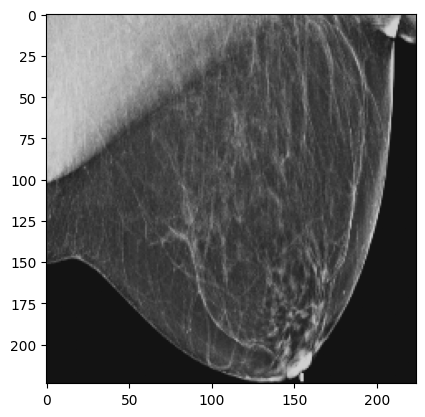

In [14]:
plt.imshow(train_dataset[0][0].permute(2, 1, 0).detach().cpu().numpy())

# Process Data

In [11]:
def norma(img):
    return 2*(img-np.min(img))/(np.max(img)-np.min(img))-1

# Show Augmentations

In [15]:
def show_aug(inputs, targets, nrows=8, ncols=4, norm=False):
    plt.figure(figsize=(15,15 ))
    plt.subplots_adjust(wspace=0.2, hspace=1)
    i_ = 0
    
    if len(inputs) > 32:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
    
        # normalization
        if norm:           
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225] 
            img = (img*std+mean).astype(np.float32)
            
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]
        
        plt.subplot(nrows, ncols, i_+1)
        plt.title(f"Label: {targets[idx].item()}")
        plt.imshow(img, cmap="bone"); 
        plt.axis('off')
 
        i_ += 1
        
    return plt.show()

torch.Size([32, 3, 224, 224]) torch.Size([32])


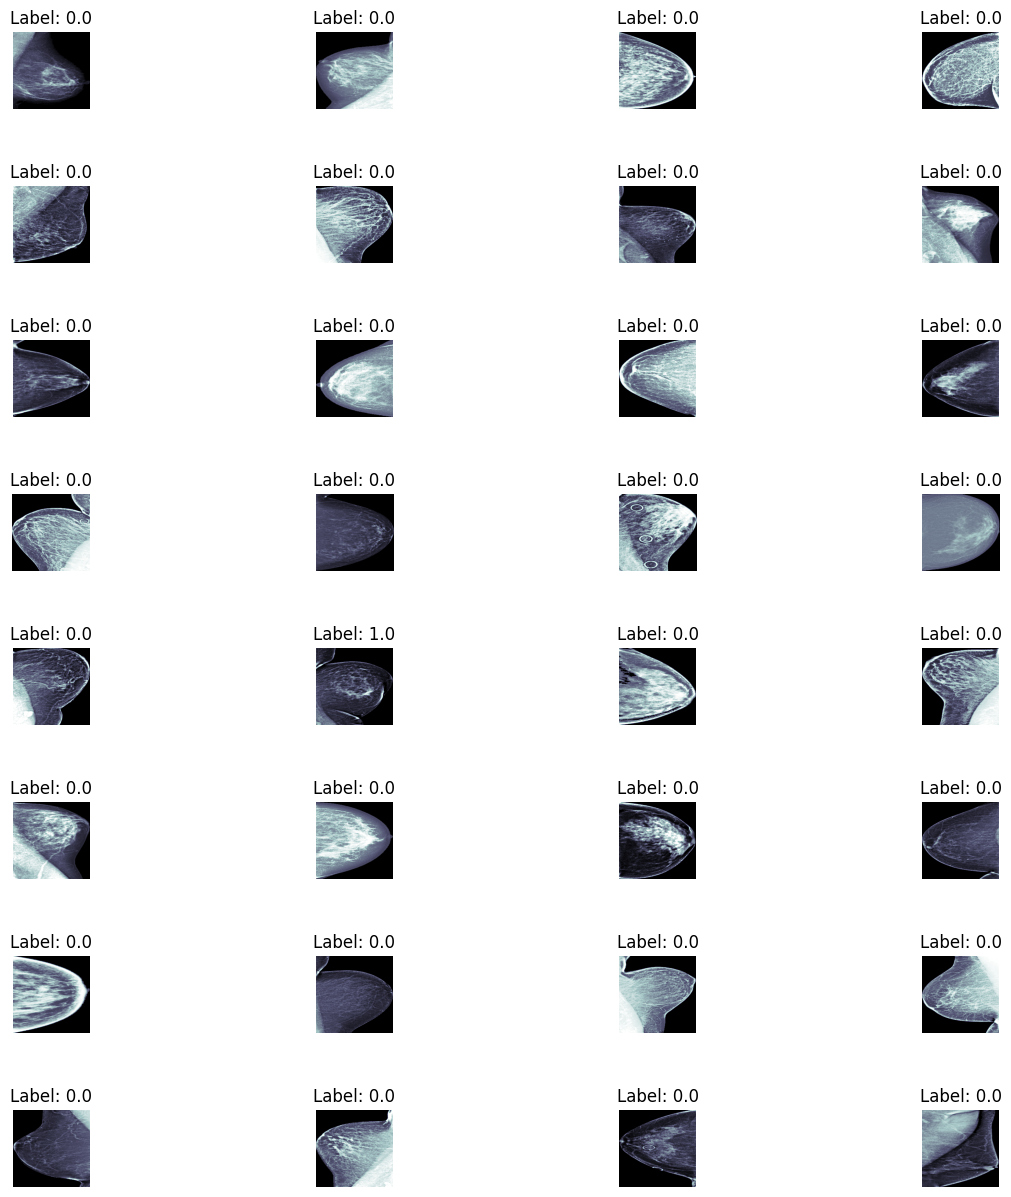

In [16]:
images, targets = next(iter(train_loader))
print(images.shape, targets.shape)

show_aug(images, targets)

torch.Size([32, 3, 224, 224]) torch.Size([32])


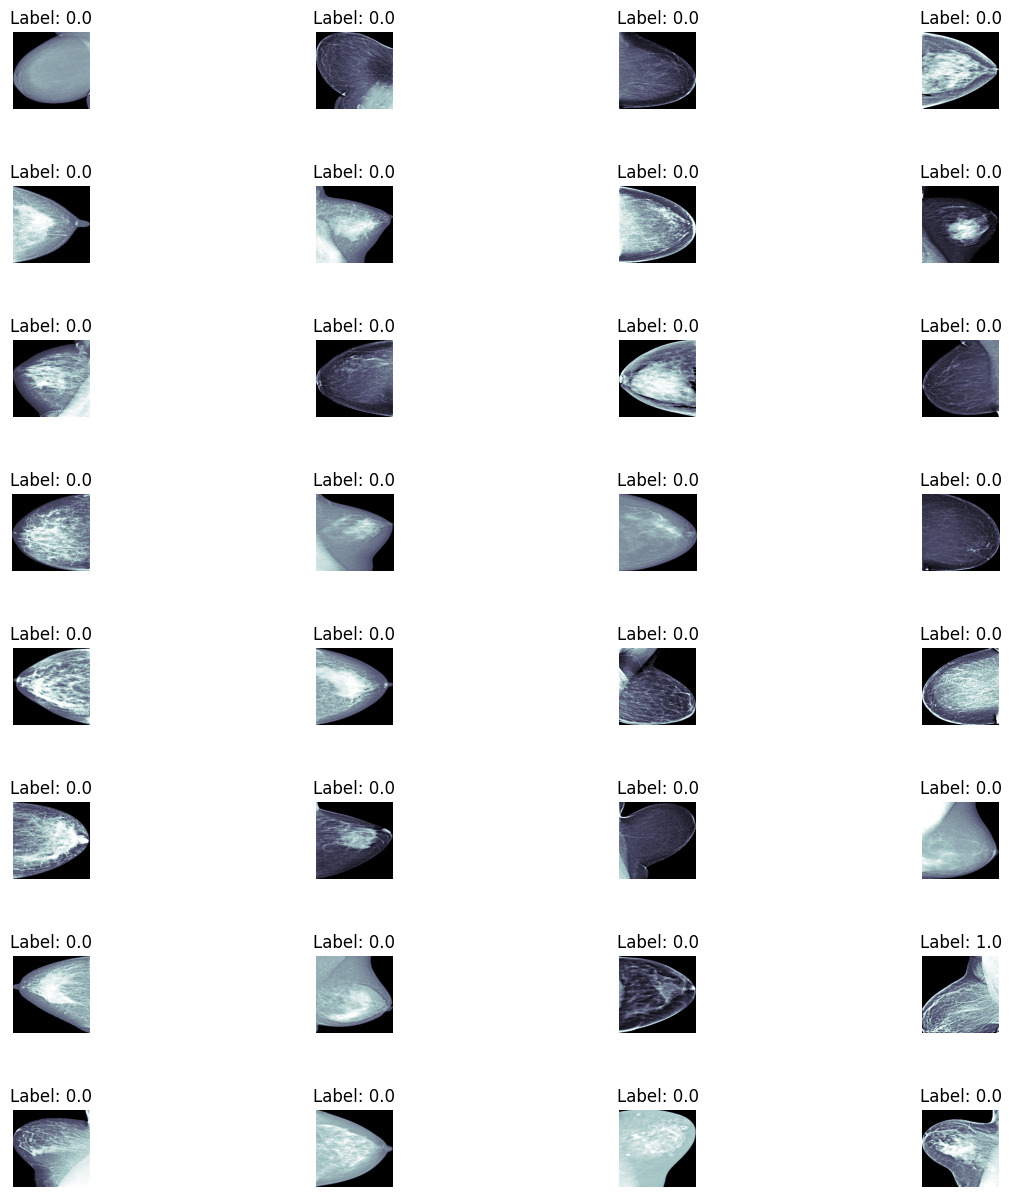

In [17]:
images, targets = next(iter(valid_loader))
print(images.shape, targets.shape)

show_aug(images, targets)

# Model

In [34]:
class InceptionV4(torch.nn.Module):
    def __init__(self, model_name="inception_v4",pretrained=True, out_dim=1):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, in_chans=3)
        # adjust classifier
        self.backbone.last_linear = nn.Linear( self.backbone.last_linear.in_features, 
                             out_dim)
    def forward(self, x):
        return self.backbone(x)

In [35]:
InceptionV4()

InceptionV4(
  (backbone): InceptionV4(
    (features): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): BasicConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (2): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (3): Mixed3a(
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        (conv): BasicConv2d(
          (conv): Conv2d(64, 96, kernel_size=(3, 3), stri

In [18]:
class Densenet121(torch.nn.Module):
    def __init__(self, model_name="tv_densenet121",pretrained=True, out_dim=1):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, in_chans=3)
        # adjust classifier
        self.backbone.classifier = nn.Linear(self.backbone.classifier.in_features, 
                             out_dim)
    def forward(self, x):
        return self.backbone(x)

In [19]:
Densenet121()

Densenet121(
  (backbone): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNormAct2d(
        64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): DenseBlock(
        (denselayer1): DenseLayer(
          (norm1): BatchNormAct2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNormAct2d(
            128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (conv2): Conv2d(128, 32, ke

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [21]:
n_epochs = 100

In [24]:
def fit(model, epochs, train_loader, valid_loader, optimizer, loss_fn):
    
    train_loss, val_loss = [], []
    f1_score_hist,precision_list,recall_list = [],[],[]
    
    for ep in tqdm(range(epochs+1)):
        print(f"{35*'='} Epoch:{ep+1} {35*'='}")
        model.train()
        
        running_loss = 0
        correct = 0
        total = 0
        # training
        for idx, (images, targets) in tqdm(enumerate(train_loader), total=len(train_loader)):
            images = images.to(device)
            targets = targets.to(device)
            
            outputs = model(images).view(-1)
            #targets = targets.unsqueeze(1)
            loss = loss_fn(outputs, targets.float())
            
                        
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            running_loss += loss.item()
            
            if idx % 1000 == 0:
                print(f"Batch: {idx} | Train Batch Loss: {loss.item():.4f}")
        
        train_loss.append(running_loss / len(train_loader))
        
        print(f"\nEpoch: {ep+1} / {epochs} | Training Loss: {np.mean(train_loss):.4f}\n")
        
        
        # validation        
        all_outputs, all_targets = [], []
        correct_t = 0
        batch_loss = 0
        total_t = 0
        with torch.no_grad():
            #model.eval()
            for idx, (images_t, targets_t) in enumerate(valid_loader):
                images_t = images_t.to(device)
                targets_t = targets_t.to(device)
                
                outputs_t = model(images_t).view(-1)
                #targets_t = targets_t.unsqueeze(1)
                loss_t = loss_fn(outputs_t, targets_t.float())
                
                batch_loss += loss_t.item()
                
                if idx % 1000 == 0:
                    print(f"\nBatch: {idx} | Valid Batch Loss: {loss_t.item():.4f}")
                
                all_outputs.extend(torch.sigmoid(outputs_t).cpu().detach().tolist())
                all_targets.extend(targets_t.cpu().detach().tolist())
        (prob_f1_score,precision,recall) = probabilistic_f1(all_targets, all_outputs)
        
        f1_score_hist.append(prob_f1_score)
        precision_list.append(precision)
        recall_list.append(recall)
        val_loss.append(batch_loss/len(valid_loader))
        
        print(f"\nEpoch: {ep+1} / {epochs} | Validation Loss: {np.mean(val_loss):.4f}\n")
        print("\nF1 Score for Epoch {} is {} and precision {} and recall {}".format(ep+1, prob_f1_score,precision,recall))
        if (ep%2)==0:
            torch.save(model.state_dict(), "C:/Users/Chi Nguyen/Desktop/breast-cancer-detection/densenet121.pth")
    print("precision, recall and f1 score ".format(np.mean(precision_list),np.mean(recall_list),np.mean(f1_score_hist)))    
    return train_loss, val_loss, f1_score_hist

In [25]:
def run(train_loader, val_loader, epochs=n_epochs):
    model = Densenet121().to(device)
    
    optimizer = torch.optim.Adam(params=model.parameters(),lr = 1e-4)
    loss_fn = nn.BCEWithLogitsLoss()
    
    train_loss, val_loss, f1_score_hist = fit(model=model, epochs=epochs, train_loader=train_loader,
        valid_loader=val_loader, optimizer=optimizer,
       loss_fn=loss_fn)
    return train_loss, val_loss, f1_score_hist

# Train the Model

In [26]:
train_loss, val_loss, f1_score_hist = run(train_loader, valid_loader, n_epochs)

  0%|          | 0/101 [00:00<?, ?it/s]

=================================== Epoch:1 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.7972
Batch: 1000 | Train Batch Loss: 0.0203

Epoch: 1 / 100 | Training Loss: 0.1122


Batch: 0 | Valid Batch Loss: 0.0245

Epoch: 1 / 100 | Validation Loss: 0.1007


F1 Score for Epoch 1 is 0.016462827802711914 and precision 0.014715067694991278 and recall 0.03136338302346003
=================================== Epoch:2 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.1183
Batch: 1000 | Train Batch Loss: 0.1099

Epoch: 2 / 100 | Training Loss: 0.1063


Batch: 0 | Valid Batch Loss: 0.0165

Epoch: 2 / 100 | Validation Loss: 0.1014


F1 Score for Epoch 2 is 0.01289480852397236 and precision 0.011761761155224228 and recall 0.02097851224243641
=================================== Epoch:3 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0172
Batch: 1000 | Train Batch Loss: 0.0183

Epoch: 3 / 100 | Training Loss: 0.1038


Batch: 0 | Valid Batch Loss: 0.0199

Epoch: 3 / 100 | Validation Loss: 0.1007


F1 Score for Epoch 3 is 0.015366327299356403 and precision 0.013900359473176676 and recall 0.026578459243166215
=================================== Epoch:4 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0205
Batch: 1000 | Train Batch Loss: 0.1106

Epoch: 4 / 100 | Training Loss: 0.1023


Batch: 0 | Valid Batch Loss: 0.0236

Epoch: 4 / 100 | Validation Loss: 0.1003


F1 Score for Epoch 4 is 0.018482364597611996 and precision 0.016613041813907357 and recall 0.03360953102439898
=================================== Epoch:5 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.1480
Batch: 1000 | Train Batch Loss: 0.2682

Epoch: 5 / 100 | Training Loss: 0.1009


Batch: 0 | Valid Batch Loss: 0.0154

Epoch: 5 / 100 | Validation Loss: 0.0999


F1 Score for Epoch 5 is 0.01802312970875535 and precision 0.01657273691838431 and recall 0.027730757640394912
=================================== Epoch:6 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.1324
Batch: 1000 | Train Batch Loss: 0.0165

Epoch: 6 / 100 | Training Loss: 0.0997


Batch: 0 | Valid Batch Loss: 0.0206

Epoch: 6 / 100 | Validation Loss: 0.1000


F1 Score for Epoch 6 is 0.02533996314868325 and precision 0.022809281687318092 and recall 0.045558965302276315
=================================== Epoch:7 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.1221
Batch: 1000 | Train Batch Loss: 0.1357

Epoch: 7 / 100 | Training Loss: 0.0986


Batch: 0 | Valid Batch Loss: 0.0130

Epoch: 7 / 100 | Validation Loss: 0.0999


F1 Score for Epoch 7 is 0.017866868050413712 and precision 0.016503463526961235 and recall 0.02668500722429911
=================================== Epoch:8 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.1453
Batch: 1000 | Train Batch Loss: 0.0145

Epoch: 8 / 100 | Training Loss: 0.0972


Batch: 0 | Valid Batch Loss: 0.0184

Epoch: 8 / 100 | Validation Loss: 0.1000


F1 Score for Epoch 8 is 0.02172507310653742 and precision 0.019742531695271234 and recall 0.03631007899390334
=================================== Epoch:9 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.1700
Batch: 1000 | Train Batch Loss: 0.1670

Epoch: 9 / 100 | Training Loss: 0.0956


Batch: 0 | Valid Batch Loss: 0.0152

Epoch: 9 / 100 | Validation Loss: 0.1009


F1 Score for Epoch 9 is 0.03092101671074303 and precision 0.02788135394213546 and recall 0.054832799323182954
=================================== Epoch:10 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.1503
Batch: 1000 | Train Batch Loss: 0.1106

Epoch: 10 / 100 | Training Loss: 0.0937


Batch: 0 | Valid Batch Loss: 0.0213

Epoch: 10 / 100 | Validation Loss: 0.1013


F1 Score for Epoch 10 is 0.03833358826844178 and precision 0.03470890984109401 and recall 0.06583395086442692
=================================== Epoch:11 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0203
Batch: 1000 | Train Batch Loss: 0.0442

Epoch: 11 / 100 | Training Loss: 0.0918


Batch: 0 | Valid Batch Loss: 0.0154

Epoch: 11 / 100 | Validation Loss: 0.1021


F1 Score for Epoch 11 is 0.03265272851243876 and precision 0.029893167681977365 and recall 0.05176862394422205
=================================== Epoch:12 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0103
Batch: 1000 | Train Batch Loss: 0.0167

Epoch: 12 / 100 | Training Loss: 0.0895


Batch: 0 | Valid Batch Loss: 0.0219

Epoch: 12 / 100 | Validation Loss: 0.1027


F1 Score for Epoch 12 is 0.030680257471705233 and precision 0.028224855122201662 and recall 0.04705397271920423
=================================== Epoch:13 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0104
Batch: 1000 | Train Batch Loss: 0.2338

Epoch: 13 / 100 | Training Loss: 0.0871


Batch: 0 | Valid Batch Loss: 0.0090

Epoch: 13 / 100 | Validation Loss: 0.1035


F1 Score for Epoch 13 is 0.02279897197790008 and precision 0.02127856010363143 and recall 0.03192288513414516
=================================== Epoch:14 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0447
Batch: 1000 | Train Batch Loss: 0.0694

Epoch: 14 / 100 | Training Loss: 0.0849


Batch: 0 | Valid Batch Loss: 0.0159

Epoch: 14 / 100 | Validation Loss: 0.1047


F1 Score for Epoch 14 is 0.04950436944377671 and precision 0.04525124692907001 and recall 0.07932836619053883
=================================== Epoch:15 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0078
Batch: 1000 | Train Batch Loss: 0.0110

Epoch: 15 / 100 | Training Loss: 0.0825


Batch: 0 | Valid Batch Loss: 0.0137

Epoch: 15 / 100 | Validation Loss: 0.1061


F1 Score for Epoch 15 is 0.03400045971287594 and precision 0.03167331204874385 and recall 0.04815204944433167
=================================== Epoch:16 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0043
Batch: 1000 | Train Batch Loss: 0.0109

Epoch: 16 / 100 | Training Loss: 0.0801


Batch: 0 | Valid Batch Loss: 0.0145

Epoch: 16 / 100 | Validation Loss: 0.1077


F1 Score for Epoch 16 is 0.03903290468270786 and precision 0.03566991325011355 and recall 0.06266556902681282
=================================== Epoch:17 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0133
Batch: 1000 | Train Batch Loss: 0.0085

Epoch: 17 / 100 | Training Loss: 0.0777


Batch: 0 | Valid Batch Loss: 0.0080

Epoch: 17 / 100 | Validation Loss: 0.1088


F1 Score for Epoch 17 is 0.02031042265022564 and precision 0.019176805301986767 and recall 0.02660019707130236
=================================== Epoch:18 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0204
Batch: 1000 | Train Batch Loss: 0.1140

Epoch: 18 / 100 | Training Loss: 0.0752


Batch: 0 | Valid Batch Loss: 0.0045

Epoch: 18 / 100 | Validation Loss: 0.1104


F1 Score for Epoch 18 is 0.04449146359037966 and precision 0.040911951994407114 and recall 0.06844547954816714
=================================== Epoch:19 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0202
Batch: 1000 | Train Batch Loss: 0.0040

Epoch: 19 / 100 | Training Loss: 0.0729


Batch: 0 | Valid Batch Loss: 0.0103

Epoch: 19 / 100 | Validation Loss: 0.1123


F1 Score for Epoch 19 is 0.03243075241532953 and precision 0.029909037838348106 and recall 0.048933700737979334
=================================== Epoch:20 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0043
Batch: 1000 | Train Batch Loss: 0.0019

Epoch: 20 / 100 | Training Loss: 0.0708


Batch: 0 | Valid Batch Loss: 0.0035

Epoch: 20 / 100 | Validation Loss: 0.1143


F1 Score for Epoch 20 is 0.0339244120755783 and precision 0.03149457989109644 and recall 0.049066488320034185
=================================== Epoch:21 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.1519
Batch: 1000 | Train Batch Loss: 0.0089

Epoch: 21 / 100 | Training Loss: 0.0686


Batch: 0 | Valid Batch Loss: 0.0090

Epoch: 21 / 100 | Validation Loss: 0.1170


F1 Score for Epoch 21 is 0.0282484157943964 and precision 0.025492666187502476 and recall 0.049768069738732074
=================================== Epoch:22 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0068
Batch: 1000 | Train Batch Loss: 0.0089

Epoch: 22 / 100 | Training Loss: 0.0666


Batch: 0 | Valid Batch Loss: 0.0045

Epoch: 22 / 100 | Validation Loss: 0.1190


F1 Score for Epoch 22 is 0.02792037794852506 and precision 0.026281046568262682 and recall 0.03720275455692267
=================================== Epoch:23 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0040
Batch: 1000 | Train Batch Loss: 0.0699

Epoch: 23 / 100 | Training Loss: 0.0647


Batch: 0 | Valid Batch Loss: 0.0091

Epoch: 23 / 100 | Validation Loss: 0.1210


F1 Score for Epoch 23 is 0.027902906795950626 and precision 0.02576286965864755 and recall 0.04178751409782443
=================================== Epoch:24 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0019
Batch: 1000 | Train Batch Loss: 0.0014

Epoch: 24 / 100 | Training Loss: 0.0628


Batch: 0 | Valid Batch Loss: 0.0149

Epoch: 24 / 100 | Validation Loss: 0.1232


F1 Score for Epoch 24 is 0.021013486364371493 and precision 0.019582936493308743 and recall 0.02968859222331286
=================================== Epoch:25 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0014
Batch: 1000 | Train Batch Loss: 0.0037

Epoch: 25 / 100 | Training Loss: 0.0611


Batch: 0 | Valid Batch Loss: 0.0050

Epoch: 25 / 100 | Validation Loss: 0.1252


F1 Score for Epoch 25 is 0.031039344634533454 and precision 0.02870566040552716 and recall 0.04599702676911178
=================================== Epoch:26 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0542
Batch: 1000 | Train Batch Loss: 0.0021

Epoch: 26 / 100 | Training Loss: 0.0594


Batch: 0 | Valid Batch Loss: 0.0005

Epoch: 26 / 100 | Validation Loss: 0.1273


F1 Score for Epoch 26 is 0.014376281149645455 and precision 0.013994781435336084 and recall 0.016135730275353852
=================================== Epoch:27 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0007
Batch: 1000 | Train Batch Loss: 0.0014

Epoch: 27 / 100 | Training Loss: 0.0579


Batch: 0 | Valid Batch Loss: 0.0012

Epoch: 27 / 100 | Validation Loss: 0.1292


F1 Score for Epoch 27 is 0.01954569125279197 and precision 0.01872679697646945 and recall 0.023689274692060343
=================================== Epoch:28 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.1156
Batch: 1000 | Train Batch Loss: 0.0048

Epoch: 28 / 100 | Training Loss: 0.0564


Batch: 0 | Valid Batch Loss: 0.0015

Epoch: 28 / 100 | Validation Loss: 0.1311


F1 Score for Epoch 28 is 0.02814806042293773 and precision 0.027012555649252288 and recall 0.033837689934488685
=================================== Epoch:29 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0269
Batch: 1000 | Train Batch Loss: 0.1378

Epoch: 29 / 100 | Training Loss: 0.0550


Batch: 0 | Valid Batch Loss: 0.0019

Epoch: 29 / 100 | Validation Loss: 0.1330


F1 Score for Epoch 29 is 0.0324390631176204 and precision 0.030653915893819883 and recall 0.04229024299880243
=================================== Epoch:30 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0185
Batch: 1000 | Train Batch Loss: 0.0019

Epoch: 30 / 100 | Training Loss: 0.0536


Batch: 0 | Valid Batch Loss: 0.0082

Epoch: 30 / 100 | Validation Loss: 0.1348


F1 Score for Epoch 30 is 0.027303214334461524 and precision 0.02606009834504212 and recall 0.03374131197561774
=================================== Epoch:31 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0149
Batch: 1000 | Train Batch Loss: 0.0007

Epoch: 31 / 100 | Training Loss: 0.0524


Batch: 0 | Valid Batch Loss: 0.0041

Epoch: 31 / 100 | Validation Loss: 0.1365


F1 Score for Epoch 31 is 0.02701034810176092 and precision 0.025545183594393013 and recall 0.03505211740726568
=================================== Epoch:32 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0015
Batch: 1000 | Train Batch Loss: 0.0008

Epoch: 32 / 100 | Training Loss: 0.0511


Batch: 0 | Valid Batch Loss: 0.0020

Epoch: 32 / 100 | Validation Loss: 0.1386


F1 Score for Epoch 32 is 0.020615934505604967 and precision 0.019798896443996884 and recall 0.02469173483628341
=================================== Epoch:33 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0019
Batch: 1000 | Train Batch Loss: 0.0025

Epoch: 33 / 100 | Training Loss: 0.0500


Batch: 0 | Valid Batch Loss: 0.0010

Epoch: 33 / 100 | Validation Loss: 0.1404


F1 Score for Epoch 33 is 0.01996777822284508 and precision 0.01942186153045038 and recall 0.022497217898658425
=================================== Epoch:34 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0006
Batch: 1000 | Train Batch Loss: 0.0008

Epoch: 34 / 100 | Training Loss: 0.0489


Batch: 0 | Valid Batch Loss: 0.0044

Epoch: 34 / 100 | Validation Loss: 0.1421


F1 Score for Epoch 34 is 0.022550330249981754 and precision 0.021786281900052842 and recall 0.026229873487065895
=================================== Epoch:35 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0006
Batch: 1000 | Train Batch Loss: 0.0023

Epoch: 35 / 100 | Training Loss: 0.0478


Batch: 0 | Valid Batch Loss: 0.0009

Epoch: 35 / 100 | Validation Loss: 0.1437


F1 Score for Epoch 35 is 0.013556770640610004 and precision 0.013137596115851111 and recall 0.015540089184132645
=================================== Epoch:36 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0167
Batch: 1000 | Train Batch Loss: 0.0025

Epoch: 36 / 100 | Training Loss: 0.0468


Batch: 0 | Valid Batch Loss: 0.0008

Epoch: 36 / 100 | Validation Loss: 0.1454


F1 Score for Epoch 36 is 0.022884197134327513 and precision 0.021948717038016603 and recall 0.027587432161881482
=================================== Epoch:37 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0087
Batch: 1000 | Train Batch Loss: 0.0006

Epoch: 37 / 100 | Training Loss: 0.0458


Batch: 0 | Valid Batch Loss: 0.0222

Epoch: 37 / 100 | Validation Loss: 0.1471


F1 Score for Epoch 37 is 0.02902762163624496 and precision 0.028005782976640498 and recall 0.03398807230881456
=================================== Epoch:38 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0005
Batch: 1000 | Train Batch Loss: 0.0118

Epoch: 38 / 100 | Training Loss: 0.0449


Batch: 0 | Valid Batch Loss: 0.0048

Epoch: 38 / 100 | Validation Loss: 0.1487


F1 Score for Epoch 38 is 0.037530352381812584 and precision 0.035028720269915624 and recall 0.052538971187999495
=================================== Epoch:39 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0026
Batch: 1000 | Train Batch Loss: 0.0018

Epoch: 39 / 100 | Training Loss: 0.0440


Batch: 0 | Valid Batch Loss: 0.0010

Epoch: 39 / 100 | Validation Loss: 0.1505


F1 Score for Epoch 39 is 0.03486006117854928 and precision 0.033040054738493196 and recall 0.04471184137634817
=================================== Epoch:40 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0006
Batch: 1000 | Train Batch Loss: 0.0020

Epoch: 40 / 100 | Training Loss: 0.0432


Batch: 0 | Valid Batch Loss: 0.0063

Epoch: 40 / 100 | Validation Loss: 0.1517


F1 Score for Epoch 40 is 0.023679662394345883 and precision 0.02288924779033088 and recall 0.02747470305938458
=================================== Epoch:41 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0006
Batch: 1000 | Train Batch Loss: 0.0037

Epoch: 41 / 100 | Training Loss: 0.0423


Batch: 0 | Valid Batch Loss: 0.0028

Epoch: 41 / 100 | Validation Loss: 0.1531


F1 Score for Epoch 41 is 0.01964592679904974 and precision 0.018889475835985426 and recall 0.02339315008068988
=================================== Epoch:42 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0013
Batch: 1000 | Train Batch Loss: 0.0017

Epoch: 42 / 100 | Training Loss: 0.0416


Batch: 0 | Valid Batch Loss: 0.0081

Epoch: 42 / 100 | Validation Loss: 0.1546


F1 Score for Epoch 42 is 0.018776463174872107 and precision 0.018114432847104452 and recall 0.021991344251337388
=================================== Epoch:43 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0003
Batch: 1000 | Train Batch Loss: 0.0028

Epoch: 43 / 100 | Training Loss: 0.0408


Batch: 0 | Valid Batch Loss: 0.0011

Epoch: 43 / 100 | Validation Loss: 0.1558


F1 Score for Epoch 43 is 0.02826484645289968 and precision 0.027016843191670296 and recall 0.034671183358352245
=================================== Epoch:44 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0003
Batch: 1000 | Train Batch Loss: 0.0018

Epoch: 44 / 100 | Training Loss: 0.0401


Batch: 0 | Valid Batch Loss: 0.0024

Epoch: 44 / 100 | Validation Loss: 0.1571


F1 Score for Epoch 44 is 0.02534264030322459 and precision 0.023812644397024237 and recall 0.034108791740913705
=================================== Epoch:45 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.1365
Batch: 1000 | Train Batch Loss: 0.0331

Epoch: 45 / 100 | Training Loss: 0.0394


Batch: 0 | Valid Batch Loss: 0.0026

Epoch: 45 / 100 | Validation Loss: 0.1586


F1 Score for Epoch 45 is 0.014071881878239706 and precision 0.013800589647294824 and recall 0.015272814922092653
=================================== Epoch:46 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0001
Batch: 1000 | Train Batch Loss: 0.0162

Epoch: 46 / 100 | Training Loss: 0.0387


Batch: 0 | Valid Batch Loss: 0.0038

Epoch: 46 / 100 | Validation Loss: 0.1598


F1 Score for Epoch 46 is 0.021459738809516085 and precision 0.020445221968475317 and recall 0.02677396619121448
=================================== Epoch:47 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0023
Batch: 1000 | Train Batch Loss: 0.0001

Epoch: 47 / 100 | Training Loss: 0.0381


Batch: 0 | Valid Batch Loss: 0.0023

Epoch: 47 / 100 | Validation Loss: 0.1609


F1 Score for Epoch 47 is 0.02746727831856557 and precision 0.02660268147901537 and recall 0.03157163715557499
=================================== Epoch:48 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0082
Batch: 1000 | Train Batch Loss: 0.0022

Epoch: 48 / 100 | Training Loss: 0.0375


Batch: 0 | Valid Batch Loss: 0.0003

Epoch: 48 / 100 | Validation Loss: 0.1620


F1 Score for Epoch 48 is 0.032989453972575945 and precision 0.0314659344870981 and recall 0.04091320615885874
=================================== Epoch:49 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0006
Batch: 1000 | Train Batch Loss: 0.0002

Epoch: 49 / 100 | Training Loss: 0.0369


Batch: 0 | Valid Batch Loss: 0.0012

Epoch: 49 / 100 | Validation Loss: 0.1631


F1 Score for Epoch 49 is 0.03448807535956156 and precision 0.03314934842402477 and recall 0.041132586176254704
=================================== Epoch:50 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0010
Batch: 1000 | Train Batch Loss: 0.0002

Epoch: 50 / 100 | Training Loss: 0.0363


Batch: 0 | Valid Batch Loss: 0.0012

Epoch: 50 / 100 | Validation Loss: 0.1645


F1 Score for Epoch 50 is 0.019914989997193103 and precision 0.01915932587640325 and recall 0.023645386410487284
=================================== Epoch:51 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0014
Batch: 1000 | Train Batch Loss: 0.0058

Epoch: 51 / 100 | Training Loss: 0.0357


Batch: 0 | Valid Batch Loss: 0.0041

Epoch: 51 / 100 | Validation Loss: 0.1658


F1 Score for Epoch 51 is 0.018240083590675544 and precision 0.01779652541937433 and recall 0.020259903913795035
=================================== Epoch:52 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0002
Batch: 1000 | Train Batch Loss: 0.0037

Epoch: 52 / 100 | Training Loss: 0.0352


Batch: 0 | Valid Batch Loss: 0.0005

Epoch: 52 / 100 | Validation Loss: 0.1669


F1 Score for Epoch 52 is 0.028371455761616038 and precision 0.027403411145672022 and recall 0.03304011640813738
=================================== Epoch:53 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0039
Batch: 1000 | Train Batch Loss: 0.0871

Epoch: 53 / 100 | Training Loss: 0.0347


Batch: 0 | Valid Batch Loss: 0.0003

Epoch: 53 / 100 | Validation Loss: 0.1677


F1 Score for Epoch 53 is 0.02614605713210807 and precision 0.025527652015938946 and recall 0.028951441598107995
=================================== Epoch:54 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0003
Batch: 1000 | Train Batch Loss: 0.0042

Epoch: 54 / 100 | Training Loss: 0.0342


Batch: 0 | Valid Batch Loss: 0.0587

Epoch: 54 / 100 | Validation Loss: 0.1686


F1 Score for Epoch 54 is 0.02563750625273956 and precision 0.024728758295584508 and recall 0.030055499875683053
=================================== Epoch:55 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0001
Batch: 1000 | Train Batch Loss: 0.0002

Epoch: 55 / 100 | Training Loss: 0.0337


Batch: 0 | Valid Batch Loss: 0.0188

Epoch: 55 / 100 | Validation Loss: 0.1694


F1 Score for Epoch 55 is 0.026644444418104693 and precision 0.025841192458132874 and recall 0.03042772664993619
=================================== Epoch:56 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0013
Batch: 1000 | Train Batch Loss: 0.0063

Epoch: 56 / 100 | Training Loss: 0.0332


Batch: 0 | Valid Batch Loss: 0.0015

Epoch: 56 / 100 | Validation Loss: 0.1706


F1 Score for Epoch 56 is 0.0347518890881875 and precision 0.032887441674416096 and recall 0.04494362426173831
=================================== Epoch:57 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0006
Batch: 1000 | Train Batch Loss: 0.0018

Epoch: 57 / 100 | Training Loss: 0.0327


Batch: 0 | Valid Batch Loss: 0.0007

Epoch: 57 / 100 | Validation Loss: 0.1714


F1 Score for Epoch 57 is 0.03213141404904698 and precision 0.031119246928406424 and recall 0.036936979752815825
=================================== Epoch:58 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0012
Batch: 1000 | Train Batch Loss: 0.0007

Epoch: 58 / 100 | Training Loss: 0.0323


Batch: 0 | Valid Batch Loss: 0.0001

Epoch: 58 / 100 | Validation Loss: 0.1725


F1 Score for Epoch 58 is 0.021309824850599818 and precision 0.02052066050692748 and recall 0.025183805709489117
=================================== Epoch:59 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0002
Batch: 1000 | Train Batch Loss: 0.0040

Epoch: 59 / 100 | Training Loss: 0.0319


Batch: 0 | Valid Batch Loss: 0.0010

Epoch: 59 / 100 | Validation Loss: 0.1736


F1 Score for Epoch 59 is 0.028090087278640524 and precision 0.026978571005299223 and recall 0.033632762248183054
=================================== Epoch:60 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0006
Batch: 1000 | Train Batch Loss: 0.0002

Epoch: 60 / 100 | Training Loss: 0.0314


Batch: 0 | Valid Batch Loss: 0.0001

Epoch: 60 / 100 | Validation Loss: 0.1746


F1 Score for Epoch 60 is 0.024775011992654854 and precision 0.02432956640657062 and recall 0.02673279546385573
=================================== Epoch:61 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0002
Batch: 1000 | Train Batch Loss: 0.0004

Epoch: 61 / 100 | Training Loss: 0.0310


Batch: 0 | Valid Batch Loss: 0.0004

Epoch: 61 / 100 | Validation Loss: 0.1754


F1 Score for Epoch 61 is 0.03328589586925332 and precision 0.031771368762081253 and recall 0.04112813616501569
=================================== Epoch:62 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0008
Batch: 1000 | Train Batch Loss: 0.0024

Epoch: 62 / 100 | Training Loss: 0.0306


Batch: 0 | Valid Batch Loss: 0.0065

Epoch: 62 / 100 | Validation Loss: 0.1763


F1 Score for Epoch 62 is 0.03489378901532607 and precision 0.03364963575412665 and recall 0.04095010499416399
=================================== Epoch:63 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0140
Batch: 1000 | Train Batch Loss: 0.0021

Epoch: 63 / 100 | Training Loss: 0.0303


Batch: 0 | Valid Batch Loss: 0.0076

Epoch: 63 / 100 | Validation Loss: 0.1770


F1 Score for Epoch 63 is 0.025595781699075473 and precision 0.024594047509510487 and recall 0.03057757247999858
=================================== Epoch:64 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.1052
Batch: 1000 | Train Batch Loss: 0.0004

Epoch: 64 / 100 | Training Loss: 0.0299


Batch: 0 | Valid Batch Loss: 0.0006

Epoch: 64 / 100 | Validation Loss: 0.1777


F1 Score for Epoch 64 is 0.02976782066117737 and precision 0.028657406963039048 and recall 0.03522783620695642
=================================== Epoch:65 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0001
Batch: 1000 | Train Batch Loss: 0.0001

Epoch: 65 / 100 | Training Loss: 0.0296


Batch: 0 | Valid Batch Loss: 0.0005

Epoch: 65 / 100 | Validation Loss: 0.1784


F1 Score for Epoch 65 is 0.026377179465054926 and precision 0.025641992129690788 and recall 0.029794114558209604
=================================== Epoch:66 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0003
Batch: 1000 | Train Batch Loss: 0.0006

Epoch: 66 / 100 | Training Loss: 0.0292


Batch: 0 | Valid Batch Loss: 0.0005

Epoch: 66 / 100 | Validation Loss: 0.1793


F1 Score for Epoch 66 is 0.01897607057655898 and precision 0.018374503287795704 and recall 0.021835593610408818
=================================== Epoch:67 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0002
Batch: 1000 | Train Batch Loss: 0.0241

Epoch: 67 / 100 | Training Loss: 0.0288


Batch: 0 | Valid Batch Loss: 0.0198

Epoch: 67 / 100 | Validation Loss: 0.1801


F1 Score for Epoch 67 is 0.015895052113735333 and precision 0.01544338210633775 and recall 0.018000933217653437
=================================== Epoch:68 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0019
Batch: 1000 | Train Batch Loss: 0.0002

Epoch: 68 / 100 | Training Loss: 0.0285


Batch: 0 | Valid Batch Loss: 0.0001

Epoch: 68 / 100 | Validation Loss: 0.1809


F1 Score for Epoch 68 is 0.018389609889951475 and precision 0.017929465885256526 and recall 0.02049338928300245
=================================== Epoch:69 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0001
Batch: 1000 | Train Batch Loss: 0.0023

Epoch: 69 / 100 | Training Loss: 0.0282


Batch: 0 | Valid Batch Loss: 0.0001

Epoch: 69 / 100 | Validation Loss: 0.1818


F1 Score for Epoch 69 is 0.013195248418586828 and precision 0.012997209941822376 and recall 0.014051669524693083
=================================== Epoch:70 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0001
Batch: 1000 | Train Batch Loss: 0.0004

Epoch: 70 / 100 | Training Loss: 0.0279


Batch: 0 | Valid Batch Loss: 0.0007

Epoch: 70 / 100 | Validation Loss: 0.1825


F1 Score for Epoch 70 is 0.028124535754421216 and precision 0.02700572370550328 and recall 0.033710937063801294
=================================== Epoch:71 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0098
Batch: 1000 | Train Batch Loss: 0.0002

Epoch: 71 / 100 | Training Loss: 0.0275


Batch: 0 | Valid Batch Loss: 0.0002

Epoch: 71 / 100 | Validation Loss: 0.1834


F1 Score for Epoch 71 is 0.00982773839578401 and precision 0.009762874552825238 and recall 0.010096048092664126
=================================== Epoch:72 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0003
Batch: 1000 | Train Batch Loss: 0.0017

Epoch: 72 / 100 | Training Loss: 0.0272


Batch: 0 | Valid Batch Loss: 0.0005

Epoch: 72 / 100 | Validation Loss: 0.1842


F1 Score for Epoch 72 is 0.0333016342580304 and precision 0.03154674409024234 and recall 0.04283240010784346
=================================== Epoch:73 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0004
Batch: 1000 | Train Batch Loss: 0.0082

Epoch: 73 / 100 | Training Loss: 0.0269


Batch: 0 | Valid Batch Loss: 0.0110

Epoch: 73 / 100 | Validation Loss: 0.1851


F1 Score for Epoch 73 is 0.0329130555864028 and precision 0.031879193239697054 and recall 0.03781903641815565
=================================== Epoch:74 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0131
Batch: 1000 | Train Batch Loss: 0.0010

Epoch: 74 / 100 | Training Loss: 0.0266


Batch: 0 | Valid Batch Loss: 0.0000

Epoch: 74 / 100 | Validation Loss: 0.1860


F1 Score for Epoch 74 is 0.025488758033371018 and precision 0.024698187189172226 and recall 0.029231469578068714
=================================== Epoch:75 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0001
Batch: 1000 | Train Batch Loss: 0.0001

Epoch: 75 / 100 | Training Loss: 0.0264


Batch: 0 | Valid Batch Loss: 0.0001

Epoch: 75 / 100 | Validation Loss: 0.1867


F1 Score for Epoch 75 is 0.023642272484406 and precision 0.023340982195424034 and recall 0.024929450781756235
=================================== Epoch:76 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0001
Batch: 1000 | Train Batch Loss: 0.0427

Epoch: 76 / 100 | Training Loss: 0.0261


Batch: 0 | Valid Batch Loss: 0.0001

Epoch: 76 / 100 | Validation Loss: 0.1875


F1 Score for Epoch 76 is 0.02115979343884267 and precision 0.020759210792666443 and recall 0.022929652822261764
=================================== Epoch:77 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0001
Batch: 1000 | Train Batch Loss: 0.0003

Epoch: 77 / 100 | Training Loss: 0.0258


Batch: 0 | Valid Batch Loss: 0.0003

Epoch: 77 / 100 | Validation Loss: 0.1882


F1 Score for Epoch 77 is 0.021040575373739136 and precision 0.02060208040882559 and recall 0.02299858410489995
=================================== Epoch:78 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0001
Batch: 1000 | Train Batch Loss: 0.0002

Epoch: 78 / 100 | Training Loss: 0.0255


Batch: 0 | Valid Batch Loss: 0.0001

Epoch: 78 / 100 | Validation Loss: 0.1890


F1 Score for Epoch 78 is 0.013683150861867993 and precision 0.013402074263598514 and recall 0.014936151745553494
=================================== Epoch:79 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0004
Batch: 1000 | Train Batch Loss: 0.0002

Epoch: 79 / 100 | Training Loss: 0.0253


Batch: 0 | Valid Batch Loss: 0.0000

Epoch: 79 / 100 | Validation Loss: 0.1897


F1 Score for Epoch 79 is 0.012815816934947056 and precision 0.012568927656284078 and recall 0.013908636748343663
=================================== Epoch:80 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0001
Batch: 1000 | Train Batch Loss: 0.0008

Epoch: 80 / 100 | Training Loss: 0.0250


Batch: 0 | Valid Batch Loss: 0.0003

Epoch: 80 / 100 | Validation Loss: 0.1904


F1 Score for Epoch 80 is 0.02352415221388984 and precision 0.022990555415773887 and recall 0.025931576658365617
=================================== Epoch:81 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0001
Batch: 1000 | Train Batch Loss: 0.0001

Epoch: 81 / 100 | Training Loss: 0.0248


Batch: 0 | Valid Batch Loss: 0.0004

Epoch: 81 / 100 | Validation Loss: 0.1912


F1 Score for Epoch 81 is 0.03099459945813101 and precision 0.029315552616377086 and recall 0.04020572264807515
=================================== Epoch:82 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0002
Batch: 1000 | Train Batch Loss: 0.0004

Epoch: 82 / 100 | Training Loss: 0.0246


Batch: 0 | Valid Batch Loss: 0.0012

Epoch: 82 / 100 | Validation Loss: 0.1920


F1 Score for Epoch 82 is 0.005863069114152705 and precision 0.005778228122948701 and recall 0.006228901817952446
=================================== Epoch:83 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0018
Batch: 1000 | Train Batch Loss: 0.0218

Epoch: 83 / 100 | Training Loss: 0.0243


Batch: 0 | Valid Batch Loss: 0.0004

Epoch: 83 / 100 | Validation Loss: 0.1928


F1 Score for Epoch 83 is 0.018795526565107808 and precision 0.01838772192338894 and recall 0.02062524075158737
=================================== Epoch:84 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0013
Batch: 1000 | Train Batch Loss: 0.0005

Epoch: 84 / 100 | Training Loss: 0.0241


Batch: 0 | Valid Batch Loss: 0.0001

Epoch: 84 / 100 | Validation Loss: 0.1938


F1 Score for Epoch 84 is 0.005757433821985394 and precision 0.0057173553989436346 and recall 0.005923528575653399
=================================== Epoch:85 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0009
Batch: 1000 | Train Batch Loss: 0.0001

Epoch: 85 / 100 | Training Loss: 0.0239


Batch: 0 | Valid Batch Loss: 0.0010

Epoch: 85 / 100 | Validation Loss: 0.1944


F1 Score for Epoch 85 is 0.03142786195743115 and precision 0.03052944387417613 and recall 0.03562085259925581
=================================== Epoch:86 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0083
Batch: 1000 | Train Batch Loss: 0.0021

Epoch: 86 / 100 | Training Loss: 0.0236


Batch: 0 | Valid Batch Loss: 0.0001

Epoch: 86 / 100 | Validation Loss: 0.1951


F1 Score for Epoch 86 is 0.021787939444814473 and precision 0.021398114562911755 and recall 0.0235004370724934
=================================== Epoch:87 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0001
Batch: 1000 | Train Batch Loss: 0.0001

Epoch: 87 / 100 | Training Loss: 0.0234


Batch: 0 | Valid Batch Loss: 0.0002

Epoch: 87 / 100 | Validation Loss: 0.1957


F1 Score for Epoch 87 is 0.019891467098458255 and precision 0.01928215968109498 and recall 0.02276948877903557
=================================== Epoch:88 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0001
Batch: 1000 | Train Batch Loss: 0.0016

Epoch: 88 / 100 | Training Loss: 0.0232


Batch: 0 | Valid Batch Loss: 0.0009

Epoch: 88 / 100 | Validation Loss: 0.1964


F1 Score for Epoch 88 is 0.021898676624779703 and precision 0.021170195326021716 and recall 0.025393974683855014
=================================== Epoch:89 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0201
Batch: 1000 | Train Batch Loss: 0.0010

Epoch: 89 / 100 | Training Loss: 0.0230


Batch: 0 | Valid Batch Loss: 0.0001

Epoch: 89 / 100 | Validation Loss: 0.1972


F1 Score for Epoch 89 is 0.00607377180226359 and precision 0.005993978801130478 and recall 0.006415383065992119
=================================== Epoch:90 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0007
Batch: 1000 | Train Batch Loss: 0.0098

Epoch: 90 / 100 | Training Loss: 0.0228


Batch: 0 | Valid Batch Loss: 0.0061

Epoch: 90 / 100 | Validation Loss: 0.1979


F1 Score for Epoch 90 is 0.009760015804823167 and precision 0.0096310204626698 and recall 0.010312507819470209
=================================== Epoch:91 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0011
Batch: 1000 | Train Batch Loss: 0.0056

Epoch: 91 / 100 | Training Loss: 0.0226


Batch: 0 | Valid Batch Loss: 0.0003

Epoch: 91 / 100 | Validation Loss: 0.1984


F1 Score for Epoch 91 is 0.025108532111660944 and precision 0.024469615133260278 and recall 0.0280367617561073
=================================== Epoch:92 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0003
Batch: 1000 | Train Batch Loss: 0.0001

Epoch: 92 / 100 | Training Loss: 0.0224


Batch: 0 | Valid Batch Loss: 0.0001

Epoch: 92 / 100 | Validation Loss: 0.1990


F1 Score for Epoch 92 is 0.006641707400139694 and precision 0.006545633760183215 and recall 0.007055963447214846
=================================== Epoch:93 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0000
Batch: 1000 | Train Batch Loss: 0.0001

Epoch: 93 / 100 | Training Loss: 0.0222


Batch: 0 | Valid Batch Loss: 0.0001

Epoch: 93 / 100 | Validation Loss: 0.1996


F1 Score for Epoch 93 is 0.014268926760966002 and precision 0.014059001626866656 and recall 0.01517530035613561
=================================== Epoch:94 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0001
Batch: 1000 | Train Batch Loss: 0.0002

Epoch: 94 / 100 | Training Loss: 0.0220


Batch: 0 | Valid Batch Loss: 0.0002

Epoch: 94 / 100 | Validation Loss: 0.2002


F1 Score for Epoch 94 is 0.01828502281083518 and precision 0.01771463330964306 and recall 0.02098820019689112
=================================== Epoch:95 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0004
Batch: 1000 | Train Batch Loss: 0.0002

Epoch: 95 / 100 | Training Loss: 0.0218


Batch: 0 | Valid Batch Loss: 0.0005

Epoch: 95 / 100 | Validation Loss: 0.2008


F1 Score for Epoch 95 is 0.023412620546954883 and precision 0.022924201826404044 and recall 0.02559380792535757
=================================== Epoch:96 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0001
Batch: 1000 | Train Batch Loss: 0.0065

Epoch: 96 / 100 | Training Loss: 0.0216


Batch: 0 | Valid Batch Loss: 0.0583

Epoch: 96 / 100 | Validation Loss: 0.2013


F1 Score for Epoch 96 is 0.036945080219810245 and precision 0.035628991360958685 and recall 0.043350295627086324
=================================== Epoch:97 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0769
Batch: 1000 | Train Batch Loss: 0.0001

Epoch: 97 / 100 | Training Loss: 0.0215


Batch: 0 | Valid Batch Loss: 0.0005

Epoch: 97 / 100 | Validation Loss: 0.2019


F1 Score for Epoch 97 is 0.010466543961736602 and precision 0.010298397789877714 and recall 0.011197873058210435
=================================== Epoch:98 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0000
Batch: 1000 | Train Batch Loss: 0.0000

Epoch: 98 / 100 | Training Loss: 0.0213


Batch: 0 | Valid Batch Loss: 0.0001

Epoch: 98 / 100 | Validation Loss: 0.2024


F1 Score for Epoch 98 is 0.039037290044417736 and precision 0.03824710909746293 and recall 0.04255392734308746
=================================== Epoch:99 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0001
Batch: 1000 | Train Batch Loss: 0.0001

Epoch: 99 / 100 | Training Loss: 0.0211


Batch: 0 | Valid Batch Loss: 0.0000

Epoch: 99 / 100 | Validation Loss: 0.2029


F1 Score for Epoch 99 is 0.026508585794438638 and precision 0.0254705851959097 and recall 0.03167139200470281
=================================== Epoch:100 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0001
Batch: 1000 | Train Batch Loss: 0.0203

Epoch: 100 / 100 | Training Loss: 0.0209


Batch: 0 | Valid Batch Loss: 0.0002

Epoch: 100 / 100 | Validation Loss: 0.2035


F1 Score for Epoch 100 is 0.020054500706294966 and precision 0.019485770749905852 and recall 0.0227052924334978
=================================== Epoch:101 ===================================


  0%|          | 0/1367 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0000
Batch: 1000 | Train Batch Loss: 0.0001

Epoch: 101 / 100 | Training Loss: 0.0208


Batch: 0 | Valid Batch Loss: 0.0002

Epoch: 101 / 100 | Validation Loss: 0.2040


F1 Score for Epoch 101 is 0.02876881971488592 and precision 0.027964627895704267 and recall 0.032508237811411274
precision, recall and f1 score 


In [27]:
def plot_model_history(model_name,
                        train_history, val_history, 
                        num_epochs):
    
    x = np.arange(num_epochs)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_history, label='train loss', lw=3, c="springgreen")
    plt.plot(x, val_history, label='validation loss', lw=3, c="deeppink")

    plt.title(f"{model_name}", fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Loss", fontsize=15)

    plt.show()

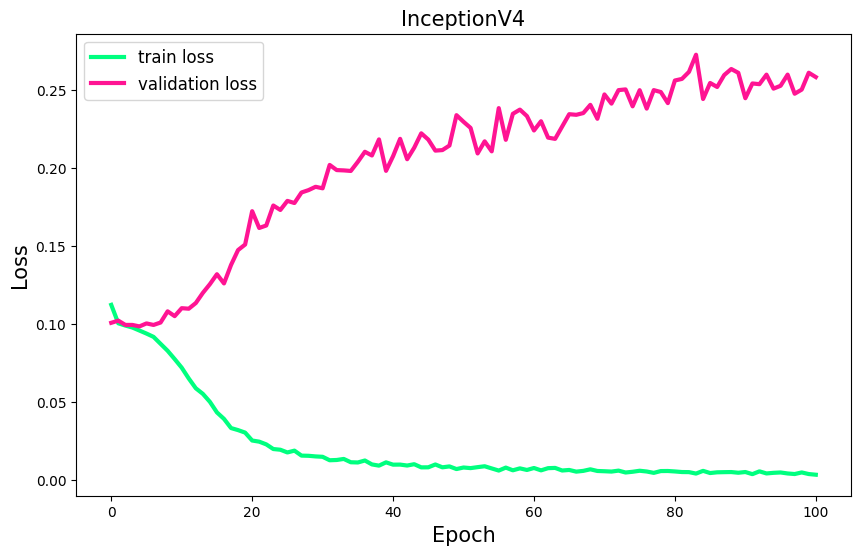

In [28]:
plot_model_history("InceptionV4", train_loss, val_loss, num_epochs=n_epochs+1)

# * predict

In [22]:
#!pip install dicomsdl
import dicomsdl

In [23]:
def read_dicom(path, fix_monochrome = True):
    dicom = dicomsdl.open(path)
    data = dicom.pixelData(storedvalue=True)  # storedvalue = True for int16 return otherwise float32
    data = data - np.min(data)
    data = data / np.max(data)
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = 1.0 - data
    return data

In [24]:
df_test = pd.read_csv("C:/Users/Chi Nguyen/Desktop/breast-cancer-detection/test.csv")
df_test["img_name"] = df_test["patient_id"].astype(str) + "/" + df_test["image_id"].astype(str) + ".png"
df_test["dcm_path"] = df_test["patient_id"].astype(str) + "/" + df_test["image_id"].astype(str) + ".dcm"

df_test.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id,img_name,dcm_path
0,2,10008,736471439,L,MLO,81,0,21,10008_L,10008/736471439.png,10008/736471439.dcm
1,2,10008,1591370361,L,CC,81,0,21,10008_L,10008/1591370361.png,10008/1591370361.dcm
2,2,10008,68070693,R,MLO,81,0,21,10008_R,10008/68070693.png,10008/68070693.dcm
3,2,10008,361203119,R,CC,81,0,21,10008_R,10008/361203119.png,10008/361203119.dcm


In [25]:
class RSNADataset1(Dataset):
    def __init__(self, df, img_folder):
        self.df = df
        self.img_folder = img_folder
        self.transform = transform
    
    def __getitem__(self, idx):
        
        img_path = os.path.join(self.img_folder, self.df["img_name"][idx])
        img = cv2.imread(img_path)

        img = cv2.resize(img, (224, 224))
        img = torch.tensor(img)
        #img = img.clone().detach()
        img = img.permute(2, 1, 0)
        
        #img = img.unsqueeze(0)
        #print(img.shape)
        return img
    
    def __len__(self):
        return len(self.df)

In [26]:
test_dataset=RSNADataset1(df=df_test, img_folder=TEST_PATH)
print((test_dataset[0]).shape)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

torch.Size([3, 224, 224])


In [28]:
img=torch.Tensor(test_dataset[0])
print(img.shape)

torch.Size([3, 224, 224])


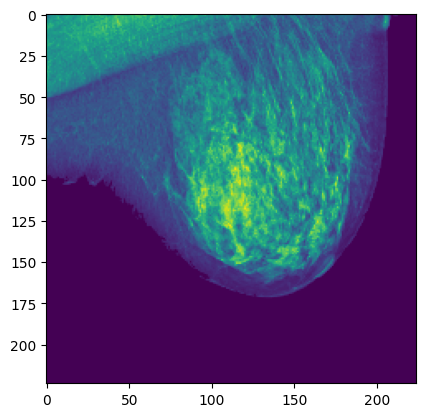

In [29]:
plt.imshow(next(iter(test_loader))[0][0])

In [30]:
for i in next(iter(test_loader)):
    print(i.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [36]:
def prediction_model(model, test_loader):    
    #model.eval()
    
    with torch.no_grad():
        preds = []
        if len(test_loader) != 1:
            # there are images and targets in loader in batches
            for images, targets in tqdm(test_loader, total=len(test_loader)):
                for im in tqdm(images):
                    pred = model(im.unsqueeze(0).float())
                    preds.append(pred)
        else:
            # just images
            for batch in tqdm(test_loader, total=len(test_loader)):
                for im in tqdm(batch):
                    pred = model(im.unsqueeze(0).float())
                    preds.append(pred)
            
        return torch.cat(preds).numpy()

In [37]:
preds = prediction_model(InceptionV4(), test_loader)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [38]:
preds

array([[-0.30547464],
       [-0.30900723],
       [-0.31688434],
       [-0.29979384]], dtype=float32)

In [153]:
def logistic_id(x):
    return (1/(1+np.exp(-x)))

In [154]:
min_ = np.min(preds)
max_ = np.max(preds)

scaled_preds = []

for p in preds:
    new_p = logistic_id(p)
    scaled_preds.append(new_p)
    
scaled_preds = np.array(scaled_preds)

In [161]:
scaled_preds

array([[0.6198474 ],
       [0.62248105],
       [0.6211243 ],
       [0.62484294]], dtype=float32)

In [162]:
sub_df = pd.read_csv("C:/Users/Chi Nguyen/Desktop/breast-cancer-detection/sample_submission.csv")
sub_df.head()

,prediction_id,cancer
0,10008_L,0.021168
1,10008_R,0.021168


In [163]:
prediction_id = df_test['patient_id'].astype(str) + "_" + df_test['laterality']
prediction_id

0    10008_L
1    10008_L
2    10008_R
3    10008_R
dtype: object

In [166]:
data = {"prediction_id": np.array(list((prediction_id))),
        "cancer": scaled_preds.T[0]
}

sub_df = pd.DataFrame(data=data)

In [167]:
sub_df

,prediction_id,cancer
0,10008_L,0.619847
1,10008_L,0.622481
2,10008_R,0.621124
3,10008_R,0.624843


In [172]:
subb = sub_df.groupby('prediction_id')[['cancer']].median()
subb

,cancer
prediction_id,
10008_L,0.621164
10008_R,0.622984


In [173]:
subb.to_csv('submission.csv',index = True)

# Fuzy rank-based Fusion using Gompertz funtion 

In [ ]:
def fuzzy_rank(CF, top):
    R_L = np.zeros(CF.shape)
    for i in range(CF.shape[0]):
        for j in range(CF.shape[1]):
            for k in range(CF.shape[2]):
                R_L[i][j][k] = 1 - math.exp(-math.exp(-2.0*CF[i][j][k]))  #Gompertz Function
    
    K_L = 0.632*np.ones(shape = R_L.shape) #initiate all values as penalty values
    for i in range(R_L.shape[0]):
        for sample in range(R_L.shape[1]):
            for k in range(top):
                a = R_L[i][sample]
                idx = np.where(a==np.partition(a, k)[k])
                #if sample belongs to top 'k' classes, R_L =R_L, else R_L = penalty value
                K_L[i][sample][idx] = R_L[i][sample][idx]

    return K_L

def CFS_func(CF, K_L):
    H = CF.shape[0] #no. of classifiers
    for f in range(CF.shape[0]):
        for i in range(CF.shape[1]):
            idx = np.where(K_L[f][i] == 0.632)
            CF[f][i][idx] = 0
    CFS = 1 - np.sum(CF,axis=0)/H
    return CFS

def Gompertz(top = 2, *argv):
    L = 0 #Number of classifiers
    for arg in argv:
        L += 1

    num_classes = arg.shape[1]
    CF = np.zeros(shape = (L,arg.shape[0], arg.shape[1]))

    for i, arg in enumerate(argv):
        CF[:][:][i] = arg

    R_L = fuzzy_rank(CF, top) #R_L is with penalties
    
    RS = np.sum(R_L, axis=0)
    CFS = CFS_func(CF, R_L)
    FS = RS*CFS

    predictions = np.argmin(FS,axis=1)